# Astrometry Correction

Original Astrometry Correction code by **Ahmed Shaban** for QSO J1004+4112

Modified by Bob Seaton to perform astrometry correction on QSO J1429+1202

Given that you have a datacube from an IFU like KCWI or MUSE, you need to make sure the astrometry of your cube is correct. The best thing is to compare the coordinates of your cube with that of an HST image.  
  
In this tutorial, we explain the steps of how to do that using `astropy` and `photutils`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from photutils.centroids import centroid_sources, centroid_com
from astropy import units as u
from astropy.coordinates import SkyCoord

cmap = 'gnuplot'

## Step (1) 
### * Make a narrow-band image from cube + modify header $\rightarrow$ save the image as fits file.
### * Make a reference image [HST + Cutout] $\rightarrow$ save the cutout as fits file

In [2]:
# Loading KCWI flux data cube fits file
# fk = fits.open('/run/media/ahmed/fedora_localhost-live/home/ahmed/Gdrive/astro/data/J1004+4112_flux.fits')
fk = fits.open("/Users/robertseaton/Desktop/Physics-NCState/---Research/Analysis/J1429/J1429_rb_flux.fits")

# print the info of the fits file (number of extensions, type of each extension)
print(fk.info())

Filename: /Users/robertseaton/Desktop/Physics-NCState/---Research/Analysis/J1429/J1429_rb_flux.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (64, 68, 2000)   float64   
None


In [3]:
# Loading KCWI variance data cube fits file
# fv = fits.open('/run/media/ahmed/fedora_localhost-live/home/ahmed/Gdrive/astro/data/J1004+4112_var.fits')
fv = fits.open("/Users/robertseaton/Desktop/Physics-NCState/---Research/Analysis/J1429/J1429_rb_var.fits")
# print the info of the fits file (number of extensions, type of each extension)
print(fv.info())

Filename: /Users/robertseaton/Desktop/Physics-NCState/---Research/Analysis/J1429/J1429_rb_var.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (64, 68, 2000)   float64   
None


In [4]:
# Loading the flux cube from index 1 of the KCWI fits file
hdr_k = fk[0].header         # header of the flux cube
data_k = fk[0].data          # the flux data cube
wcs_k = WCS(hdr_k).celestial # the World Coordinate System (WCS) of the flux cube

# Removing all the NaNs from the flux cube before making white-light or narrow-band image
q_nan = np.isnan(data_k) 
data_k[q_nan] = 0.0

# making a white-light image from the flux data-cube by summing 
# the flux along the wavelength axis
wl_k = np.sum(data_k, axis=0)


# Loading the variance cube from index 2 of the KCWI fits file
var_k = fv[0].data                   # the variance data cube
hdr_k_var = fv[0].header             # header of the variance cube
wcs_k_var = WCS(hdr_k_var).celestial # The WCS of the variance cube

In [5]:
# Loading the reference image fits file (e.g., HST image)
# fh = fits.open('/run/media/ahmed/fedora_localhost-live/home/ahmed/Gdrive/astro/data/J1004+4112_HST/j9e305020_drc.fits')
fh = fits.open("/Users/robertseaton/School/github_repos/CGM-learning/data/data_idpw02010_WFC3_IR_F160W_drz.fits")
fh.info()

Filename: /Users/robertseaton/School/github_repos/CGM-learning/data/data_idpw02010_WFC3_IR_F160W_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      81   (1090, 962)   float32   


In [6]:
hdr_h = fh[0].header    # Reference image header
data_h = fh[0].data     # Reference image 2D data
wcs_h = WCS(hdr_h)      # WCS of the reference image

## Step (2)
### * Display NB & HST image using `%matplotlib Qt`
### * Identify the locations of your point sources in both the NB & HST images
####  - ($x_{guess}$, $y_{guess}$) $\rightarrow$ NB
####  - ($x_{guess}$, $y_{guess}$) $\rightarrow$ HST

#### Narrowband for MUSE

In [7]:
def show_whitelight_image(ax, wl_image):
    ax.imshow(wl_image, origin='lower', interpolation='nearest', cmap=cmap, vmin=0, vmax=0.3*wl_image.max())
    ax.set_title("White Light from the data cube")


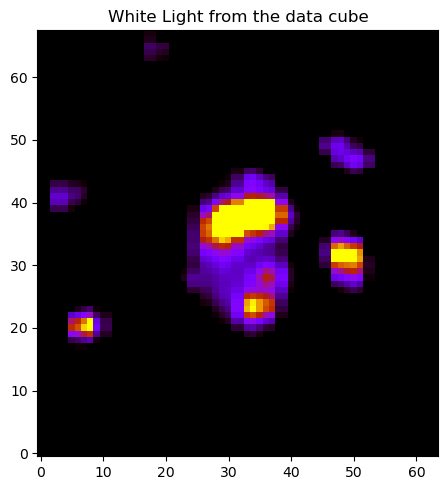

In [8]:
# %matplotlib qt
%matplotlib inline

plt.close()
# fig = plt.figure(1, figsize=(6,4), dpi=200)
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111)
show_whitelight_image(ax1, wl_k)
fig.tight_layout()
plt.show()

#### guess coordinates for KCWI image of J1429+1202

In [9]:
# Guessing the x and y coordinates of three point sources in the narrow-band 
# image of the data cube
x_guess_k = [ 8, 34, 48]
y_guess_k = [ 20, 23, 32]

#### HST Image 

In [10]:
def show_hst_image(ax, hst_image):
    # ax1.imshow(data_h, origin='lower', interpolation='nearest', cmap=cmap, vmin=0.001, vmax=0.07)
    ax.imshow(hst_image, origin='lower', interpolation='nearest', cmap=cmap, vmin=1, vmax=10)
    # ax1.set_title("HST "+hdr_h["PHOTMODE"])
    ax.set_title("HST Image")
    ax.set_xlim([470, 594])
    ax.set_ylim([606, 720])


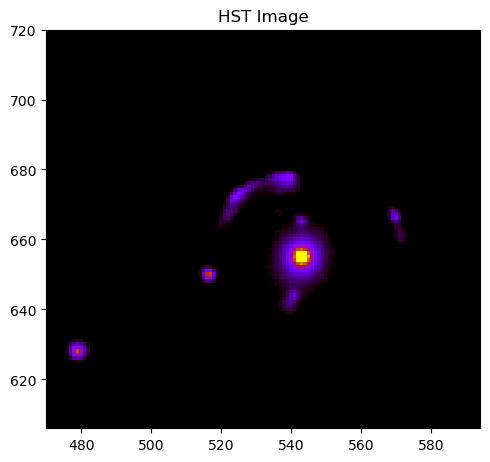

In [11]:
# %matplotlib qt
%matplotlib inline
plt.close()
# fig = plt.figure(1, figsize=(6,4), dpi=200)
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111)
show_hst_image(ax1, data_h)
fig.tight_layout()
plt.show()

#### guess coordinates for HST

In [12]:
# Guessing the x and y coordinates of three point sources in the narrow-band 
# image of the data cube
x_guess_h = [ 479, 541, 570]#[2055, 2218, 2290, 2378]#[2209, 2228, 2299, 2381]
y_guess_h = [ 628, 643, 666]#[3141, 3078, 3103, 3330]#[3315, 3125, 2381, 3377]

In [13]:
type(wcs_k), hdr_k["CDELT2"]  * 3600.

(astropy.wcs.wcs.WCS, 0.291456)

### Defining a function that transforms coordinates using the `wcs` of both instruments

In [14]:
def transform_pixels(x1, y1, wcs1, wcs2):
    """ A function to transform the (x,y) pixels from one WCS to another.
    Parameters
    ----------
    x1: float or array_like
        x-coordinate of the pixel from data with wcs1
    y1: float or array_like 
        y-coordinate of the pixel from data with wcs1
    wcs1: astropy WCS object
        The world coordinate system of the first data set.
    wcs2: astropy WCS object
        The world coordinate system of the second data set.
        
    Returns
    -------
    x2: float or array_like
        The corresponding x-coordinate from the data set with wcs2
    y2: float or array_like
        The corresponding y-coordinate from the data set with wcs2
    
    """
    r, d = wcs1.pixel_to_world_values(x1, y1)
    x2, y2 = wcs2.world_to_pixel_values(r, d)
    return x2, y2

In [15]:
hdr_h#["CD2_2"]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1090                                                  
NAXIS2  =                  962                                                  
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'idpw02lrq                         ' / rootname of the observation set
EXPNAME = 'idpw02lrq                ' / exposure identifier                     
BUNIT   = 'ELECTRONS/S'        / brightness units                               
                                                                                
              / World Coordi

In [16]:
hdr_k

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    3                                                  
NAXIS1  =                   64                                                  
NAXIS2  =                   68                                                  
NAXIS3  =                 2000                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
EQUINOX =                 2000                                                  
CRVAL1  =        217.4782904

## Step (3)
### Run `photutils` to get the exact coordiantes of your point sources for both NB & HST.
#### -  ($x_{com}$, $y_{com}$) $\rightarrow$ NB
#### -  ($x_{com}$, $y_{com}$) $\rightarrow$ HST

7
15
[ 7.03423891 34.32500274 48.80922641] [20.3296484  23.52130757 31.440289  ]
[479.0524424  541.02015934 569.96173874] [628.02381004 643.98819553 665.66938802]


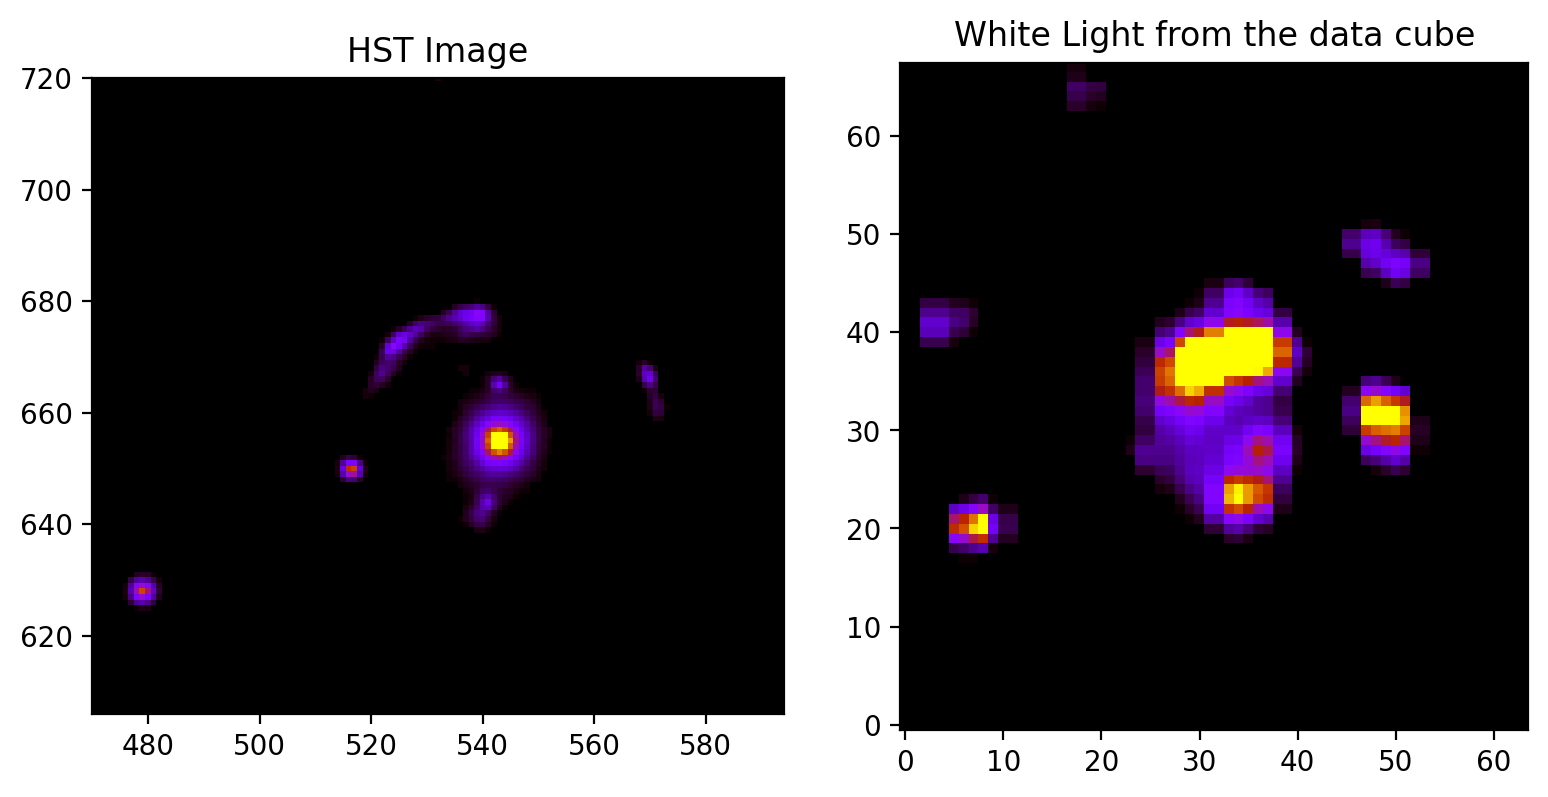

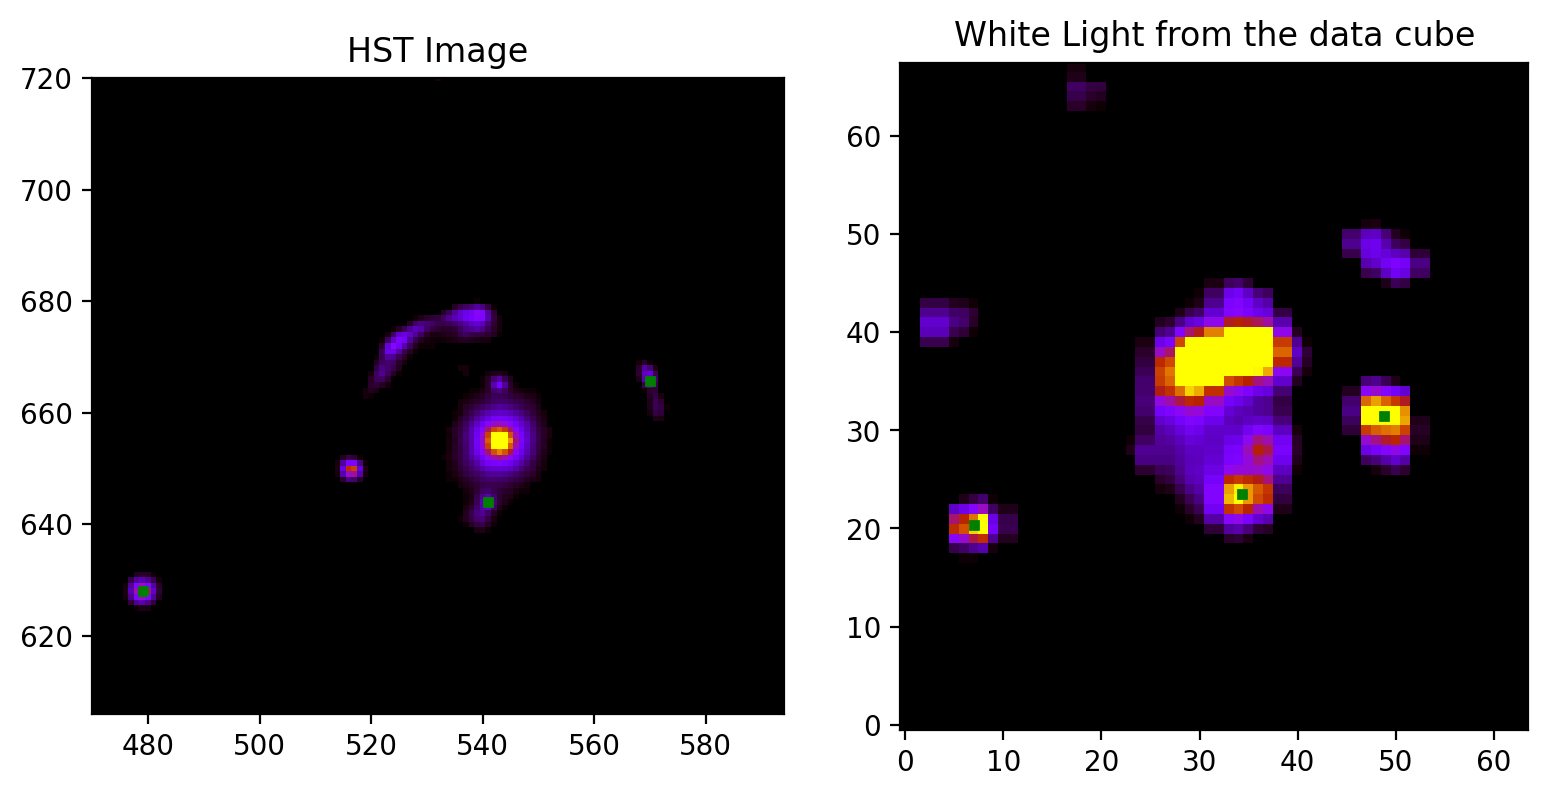

In [17]:
# selecting a box size of 3 arcseconds for both instruments
box_size_k = int(2 / (hdr_k["CDELT2"] * 3600.))#int(2 / (hdr_k["CD2_2"] * 3600.))
pixel_hst = ( np.sqrt(hdr_h["CD1_2"]**2 +hdr_h["CD1_1"]**2 )* 3600)
box_size_h = int(2 / pixel_hst)

# Making sure that the box size is odd-integer for both data-sets
if box_size_k % 2 == 0:
    box_size_k += 1
if box_size_h % 2 == 0:
    box_size_h += 1
print(box_size_k)
print(box_size_h)
# calculating the Center of Mass (x, y) coordinates of the points sources in the MUSE white light image    
x_com_k, y_com_k = centroid_sources(wl_k, x_guess_k, y_guess_k, 
                                    box_size=box_size_k, centroid_func=centroid_com)

# calculating the Center of Mass (x, y) coordinates of the points sources in the reference image    
x_com_h, y_com_h = centroid_sources(data_h, x_guess_h, y_guess_h, 
                                    box_size=box_size_h, centroid_func=centroid_com)

print(x_com_k, y_com_k)
print(x_com_h, y_com_h)

# Make a figure to show the two images together
plt.close()
fig = plt.figure(1, figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
show_hst_image(ax1, data_h)

ax2 = fig.add_subplot(122)
show_whitelight_image(ax2, wl_k)

fig.tight_layout()
plt.show()


# Make a figure to show the two images together with the point-sources marked in both images
c_mark = 'g'   # color of the point sources markers
mark = 3
plt.close()
fig = plt.figure(1, figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
show_hst_image(ax1, data_h)

# add the markers 
ax1.plot(x_com_h, y_com_h, 's', c=c_mark, markersize=mark)

ax2 = fig.add_subplot(122)
show_whitelight_image(ax2, wl_k)

# add the markers 
ax2.plot(x_com_k, y_com_k, 's', c=c_mark, markersize=mark)

fig.tight_layout()
plt.show()


## Step (4)
### Convert from ($x_{com}$, $y_{com}$) to RA and DEC for both NB & HST

In [18]:
from copy import deepcopy
hdr_k["CD1_1"] = deepcopy(hdr_k["CDELT1"])
hdr_k["CD2_2"] = deepcopy(hdr_k["CDELT2"])

hdr_k_var["CD1_1"] = deepcopy(hdr_k_var["CDELT1"])
hdr_k_var["CD2_2"] = deepcopy(hdr_k_var["CDELT2"])
wcs_k = WCS(hdr_k).celestial

ra_m, dec_m = wcs_k.pixel_to_world_values(x_com_k, y_com_k)
ra_h, dec_h = wcs_h.pixel_to_world_values(x_com_h, y_com_h)



In [19]:
hdr_k

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    3                                                  
NAXIS1  =                   64                                                  
NAXIS2  =                   68                                                  
NAXIS3  =                 2000                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
EQUINOX =                 2000                                                  
CRVAL1  =        217.4782904

In [20]:
# wcs_k_u, wcs_h
wcs_h

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 217.4792181448134  12.03705804423026  
CRPIX : 545.0  481.0  
CD1_1 CD1_2  : -3.5276711744512e-05  -4.9693349775413e-06  
CD2_1 CD2_2  : -4.9693349775413e-06  3.5276711744512e-05  
NAXIS : 1090  962

## Step (5)
### Obtain the median or mean offset using all the sources that you have

In [21]:
c_m = SkyCoord(ra_m, dec_m, frame='icrs', unit='deg')
c_h = SkyCoord(ra_h, dec_h, frame='icrs', unit='deg')

offsets = c_m.separation(c_h)
print("SkyCoord Offsets in arcseconds: ", offsets.arcsecond)
print("SkyCoord Offsets in degrees: ", offsets.degree)



# Calculating the difference between the RA, DEC of the point sources in both images
delta_ra = ra_h - ra_m           # point sources offset in RA (in degrees)
delta_dec = dec_h - dec_m        # point sources offset in Decl. (in degress)

median_delta_ra =  np.median(delta_ra)   # the median offset in RA of all point sources (in degrees) 
median_delta_dec = np.median(delta_dec)  # the median offset in Decl. of all point sourcs (in degrees)
print("--------------------------------")
print("RA Offset: ", delta_ra * 3600., "arcseconds")
print("Decl. Offset: ", delta_dec * 3600., "arcseconds") 
print("sqrt(D_RA^2 + D_Decl^2): ", np.sqrt(delta_ra**2 + delta_dec**2) * 3600., "arcseconds")
print("--------------------------------")
print("Median RA offset: ", np.median(delta_ra)*3600., "arcseconds")
print("Median Decl. offset: ", np.median(delta_dec)*3600., "arcseconds")



SkyCoord Offsets in arcseconds:  [2.17006146 2.00541085 2.0857444 ]
SkyCoord Offsets in degrees:  [0.00060279 0.00055706 0.00057937]
--------------------------------
RA Offset:  [1.77449408 1.568752   1.73047884] arcseconds
Decl. Offset:  [1.30284405 1.29144038 1.21907402] arcseconds
sqrt(D_RA^2 + D_Decl^2):  [2.20141588 2.03194515 2.11676604] arcseconds
--------------------------------
Median RA offset:  1.7304788376009128 arcseconds
Median Decl. offset:  1.2914403795640794 arcseconds


## Step (6) 
### Update the NB header

In [22]:
from copy import deepcopy
from time import gmtime, strftime

# copying the flux data-cube header and modifying it by applying the offset for the (RA, Decl.)
hdr_k_new = deepcopy(hdr_k)
hdr_k_new["CRVAL1"] = hdr_k["CRVAL1"] + median_delta_ra
hdr_k_new["CRVAL2"] = hdr_k["CRVAL2"] + median_delta_dec
hdr_k_new['COMMENT'] = '  NOTE: Astrometry corrected using HST image '+ strftime("%Y-%m-%d %H:%M:%S", gmtime())

# copying the flux data-cube header and modifying it by applying the offset for the (RA, Decl.)
hdr_k_var_new = deepcopy(hdr_k_var)
hdr_k_var_new["CRVAL1"] = hdr_k_var["CRVAL1"] + median_delta_ra
hdr_k_var_new["CRVAL2"] = hdr_k_var["CRVAL2"] + median_delta_dec
hdr_k_var_new['COMMENT'] = '  NOTE: sAstrometry corrected using HST image '+ strftime("%Y-%m-%d %H:%M:%S", gmtime())

hdr_k_new

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    3                                                  
NAXIS1  =                   64                                                  
NAXIS2  =                   68                                                  
NAXIS3  =                 2000                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT   NOTE: Astrometry corrected using HST image 2023-10-19 17:09:34        
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
EQUINOX =                 20

## Step (7) 
### Check Results visually

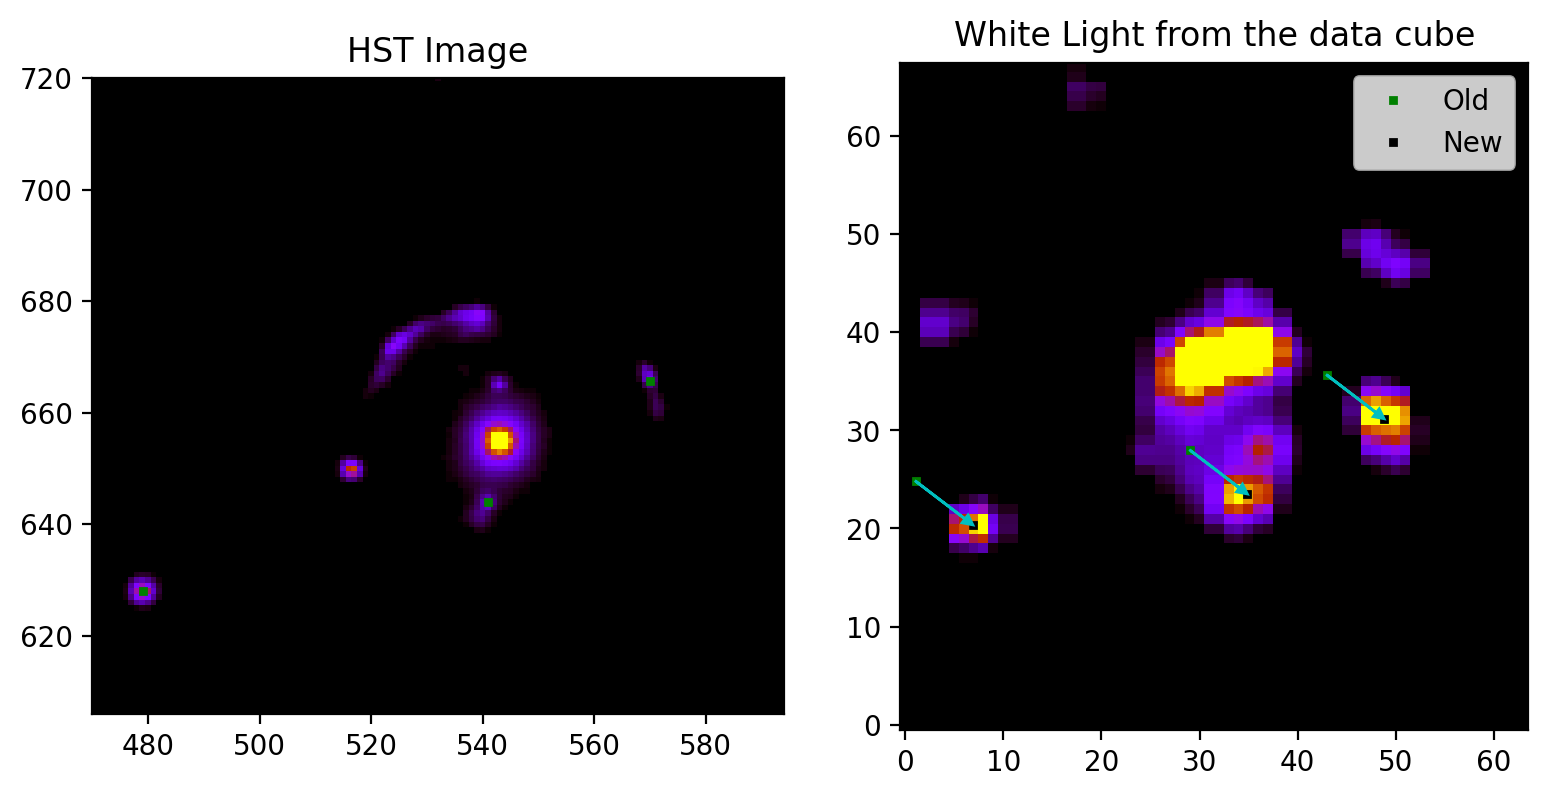

In [34]:
wcs_k_new = WCS(hdr_k_new).celestial
 
x_old, y_old = transform_pixels(x_com_h, y_com_h, wcs_h, wcs_k)     # pixels of the point sources using the old header of the data cube
x_new, y_new = transform_pixels(x_com_h, y_com_h, wcs_h, wcs_k_new) # pixels of the point sources using the new header of the data cube

mark = 2
plt.close()
fig = plt.figure(1, figsize=(8,4), dpi=200)
ax1 = fig.add_subplot(121)
show_hst_image(ax1, data_h)

ax1.plot(x_com_h, y_com_h, 's', c=c_mark, markersize=mark)

ax2 = fig.add_subplot(122)
show_whitelight_image(ax2, wl_k)
del_x = x_new - x_old
del_y = y_new - y_old

for pt in range(len(x_old)):
    ax2.arrow(x_old[pt], y_old[pt], del_x[pt], del_y[pt], color='c', head_width=1, head_length=1, length_includes_head=True, zorder=10)
ax2.plot(x_old, y_old, 's', c=c_mark, markersize=mark, label="Old")
ax2.plot(x_new, y_new, 's', c='k', markersize=mark, label="New")

ax2.legend(loc=0)

fig.tight_layout()
plt.show()

## Step (8)
### Update datacube header
add a keyword for saving for either MUSE or KCWI

In [ ]:
flux_k_hdu_new  = fits.PrimaryHDU(data_k, hdr_k_new)
var_k_hdu_new = fits.PrimaryHDU(var_k, hdr_k_var_new)

hdul_flux_k_new = fits.HDUList([flux_k_hdu_new])
hdul_var_k_new = fits.HDUList([var_k_hdu_new])

save = True #True#False
if save:
    dir = "/Users/robertseaton/School/github_repos/CGM-learning/data/"
    flux_filename = "J1429+1202_KCWI_corrected_flux.fits"
    var_filename = "J1429+1202_KCWI_corrected_var.fits"
    hdul_flux_k_new.writeto(dir+flux_filename, overwrite=True)
    hdul_var_k_new.writeto(dir+var_filename, overwrite=True)
    